# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import ElasticNetCV, LinearRegression, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin

from IPython.display import display, Markdown

# Summary

Under the time-contraint of 4 business days, I needed to develop a model to predict the sale price of houses in Ames, Iowa with the [this](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) data dictionary as a guide.

Given the sheer number of features inclusive of ordinal and categorical features I knew I needed to find a way to filter the best features. I made extensive use of the pipeline function to be able to layer various preprocessing techniques quickly.

This model ended up winning this small competition:
*Kaggle competition [link](https://www.kaggle.com/c/ames-iowa-housing-louisville/)*

# EDA

In [2]:
data = pd.read_csv('./datasets/train.csv')

In [3]:
print(data.columns)

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [4]:
print(f"Count of categorical variables: {data.select_dtypes('O').count().count()}")
print(f"Count of numerical variables:   {data.select_dtypes('number').count().count()}")

Count of categorical variables: 42
Count of numerical variables:   39


## Outlier Analysis

Based on the data dictionary, it mentions potential for outliers with respect to square footage. I decided to take a look below.

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,0,480,Gd,NaN,NaN,0,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


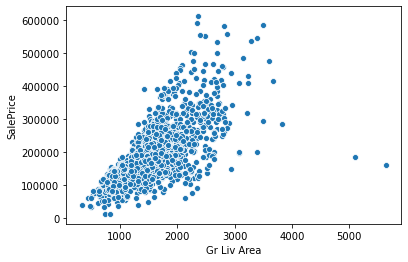

In [5]:
sns.scatterplot(data=data, x='Gr Liv Area', y='SalePrice');
data[data['Gr Liv Area'] > 4000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
471,2116,906426060,50,RL,NaN,159000,Pave,NaN,IR2,Low,...,0,0,NaN,NaN,Shed,500,6,2007,WD,277000
694,2072,905301050,20,RL,NaN,115149,Pave,NaN,IR2,Low,...,0,0,NaN,NaN,NaN,0,6,2007,WD,302000


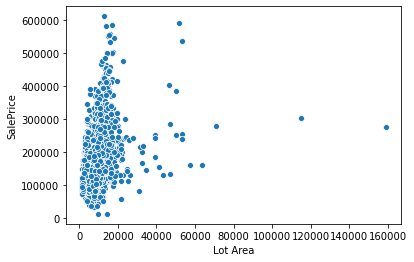

In [6]:
sns.scatterplot(data=data, x='Lot Area', y='SalePrice');
data[data['Lot Area'] > 100_000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,0,480,Gd,NaN,NaN,0,1,2008,New,160000
1335,1266,535427070,20,RL,313.0,27650,Pave,NaN,IR2,HLS,...,0,0,NaN,NaN,NaN,0,11,2008,WD,242000


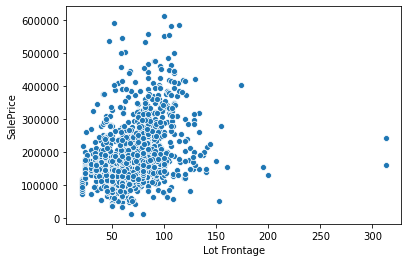

In [7]:
sns.scatterplot(data=data,x='Lot Frontage', y='SalePrice');
data[data['Lot Frontage'] > 250]

- Looking at the above charts, as a goal for building a predictive model I decided to remove the outliers.

In [8]:
data.drop(data[data['Gr Liv Area'] > 4_000].index, inplace=True)
data.drop(data[data['Lot Area'] > 100_000].index, inplace=True)
data.drop(data[data['Lot Frontage'] > 250].index, inplace=True)

## NaN Values

In [9]:
data.isnull().sum()[data.isnull().sum() !=0].sort_values(ascending=False)

Pool QC           2038
Misc Feature      1983
Alley             1906
Fence             1646
Fireplace Qu      1000
Lot Frontage       328
Garage Yr Blt      114
Garage Cond        114
Garage Qual        114
Garage Finish      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Garage Area          1
Total Bsmt SF        1
dtype: int64

## Correlation Exploration

In [10]:
y_corr = np.abs(data.corr()['SalePrice'])
y_corr_mean = y_corr.mean()
y_corr = pd.DataFrame(data=y_corr, columns=y_corr.index)[y_corr[y_corr > y_corr_mean].index]['SalePrice']

y_corr.sort_values(ascending=False)

SalePrice          1.000000
Overall Qual       0.803817
Gr Liv Area        0.719136
Total Bsmt SF      0.665011
Garage Area        0.655706
Garage Cars        0.648897
1st Flr SF         0.647787
Year Built         0.573492
Year Remod/Add     0.550209
Full Bath          0.537717
Garage Yr Blt      0.536234
Mas Vnr Area       0.519321
TotRms AbvGrd      0.510635
Fireplaces         0.472273
BsmtFin SF 1       0.444962
Lot Frontage       0.363566
Lot Area           0.351738
Open Porch SF      0.338802
Wood Deck SF       0.327503
Half Bath          0.285050
Bsmt Full Bath     0.284534
PID                0.256532
2nd Flr SF         0.249560
Bsmt Unf SF        0.190830
Bedroom AbvGr      0.136869
Enclosed Porch     0.135227
Screen Porch       0.135198
Kitchen AbvGr      0.125260
Overall Cond       0.098158
MS SubClass        0.086393
Id                 0.052369
3Ssn Porch         0.048949
Bsmt Half Bath     0.047708
Low Qual Fin SF    0.041468
Mo Sold            0.032022
Pool Area          0

# Custom Transformers

## Ordinal Features

In [11]:
class CustomOrdinals(BaseEstimator,TransformerMixin):
    """This class takes AMES Housing Data as an input and outputs a dataframe with ordinal features mapped to numeric values"""
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        X_ = X.copy()
        
        X_.loc[:,'Fence'] = X_['Fence'].map({'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, np.nan:0})
        X_.loc[:,'Garage Finish'] = X_['Garage Finish'].map({'Fin': 3, 'RFn':2, 'Unf':1, 'NA':0, np.nan:0})
        X_.loc[:,'Bsmt Exposure'] = X_['Bsmt Exposure'].map({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'Na':0, np.nan:0})


        bsmt_map = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.nan: 0, 'NA':0}

        X_.loc[:,'BsmtFin Type 1'] = X_['BsmtFin Type 1'].map(bsmt_map)
        X_.loc[:,'BsmtFin Type 2'] = X_['BsmtFin Type 2'].map(bsmt_map)


        ordinal_qual_map = {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:0}
        cols = ['Exter Qual', 'Exter Cond', 'Bsmt Qual','Bsmt Cond', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC']

        for i in cols:
            X_.loc[:,i] = X[i].map(ordinal_qual_map)

        X_.loc[:,'Garage Type']=X_['Garage Type'].fillna('None')
        X_.loc[:,'Misc Feature']=X_['Misc Feature'].fillna('None')
        X_.loc[:,'Mas Vnr Type']=X_['Mas Vnr Type'].fillna('None')
        X_.loc[:,'Alley']=X_['Alley'].fillna('None')

        return X_

## Dummy Variables

In [12]:
class CustomDummies(BaseEstimator,TransformerMixin):
    """This class takes an input of the AMES Housing dataframe and outputs it with categorical variables encoded into dummy variables"""

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        to_drop = ['PID', 'Id']
        
        X_ = X.copy()       
        X_.loc[:, 'MS SubClass'] = X_['MS SubClass'].astype(str)

        X_ = pd.get_dummies(data=X_,
                      columns=X_
                      .drop(columns=to_drop)
                      .dtypes[X_.dtypes=='object']
                      .index.append(pd.Index(['Mo Sold'])),
                      drop_first=True)
        return X_.drop(columns=to_drop)

## Column Staging

In [13]:
class ColumnStager(BaseEstimator,TransformerMixin):
    """This class is for fitting test data for any missing columns gotten from CustomDummies. 
    It outputs the test dataframe with unknown columns dropped and missing columns with 0s."""
    
    def fit(self, X, y=None):
        self.staging_cols = X.copy().columns
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        
        cols = [i for i in self.staging_cols if i not in X_.columns]
        ind = X_.index
        cols_to_drop = [i for i in X_.columns if i not in self.staging_cols]
        
        if len(cols) > 0:         
            X_ = pd.concat([X_, pd.DataFrame(data = [[0]*len(cols) for i in range(len(X_))], columns=cols, index=ind)],axis=1)
            
        if len(cols_to_drop) > 0:           
            X_ = X_.drop(columns=cols_to_drop)
        
        self.cols_added = cols
            
        return X_

## Feature Selector

In [14]:
class SelectBestFeats(BaseEstimator, TransformerMixin):
    """Takes the input of a model, and dataframe and selects the features with the strongest n coefficients"""
    
    def __init__(self, model, n):
        self.model = model
        self.n = n
        
    def fit(self, X, y):
        X_ = X.copy()
        y_ = y.copy()
        
        self.model.fit(X_, y_)
        
        index = self.model.coef_
        index = [(j, i) for (i, j) in enumerate(index)]
        index.sort(reverse=True)

        index = [i for j, i in index[:self.n]]
        
        self.index_cols = index
        
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        return X_[:,self.index_cols]

# Model

In [15]:
X = data.drop(columns='SalePrice')
y = np.log(data['SalePrice'])

un_log = lambda x: np.power(np.e, x) # for y transformations

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
pipe = Pipeline([
    ('ords', CustomOrdinals()),
    ('dummies', CustomDummies()),
    ('stage', ColumnStager()),
    ('ss', StandardScaler()),
    ('imp', SimpleImputer(strategy='median')),
    ('sbf1', SelectBestFeats(LassoCV(max_iter=1_000_000, random_state=42), n=40)),
    ('poly', PolynomialFeatures()),
    ('sbf2', SelectBestFeats(LassoCV(max_iter=1_000_000, random_state=42), n=22)),
    ('power', PowerTransformer(standardize=False)),
    ('model', ElasticNetCV(max_iter=1_000_000, verbose=1, random_state=42))
],
verbose = 1)

pipe.fit(X_train, y_train)

[Pipeline] ............. (step 1 of 10) Processing ords, total=   0.0s
[Pipeline] .......... (step 2 of 10) Processing dummies, total=   0.0s
[Pipeline] ............ (step 3 of 10) Processing stage, total=   0.0s
[Pipeline] ............... (step 4 of 10) Processing ss, total=   0.0s
[Pipeline] .............. (step 5 of 10) Processing imp, total=   0.0s
[Pipeline] ............. (step 6 of 10) Processing sbf1, total=   0.2s
[Pipeline] ............. (step 7 of 10) Processing poly, total=   0.0s
[Pipeline] ............. (step 8 of 10) Processing sbf2, total=   1.4s
[Pipeline] ............ (step 9 of 10) Processing power, total=   0.1s
[Pipeline] ........... (step 10 of 10) Processing model, total=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Pipeline(steps=[('ords', CustomOrdinals()), ('dummies', CustomDummies()),
                ('stage', ColumnStager()), ('ss', StandardScaler()),
                ('imp', SimpleImputer(strategy='median')),
                ('sbf1',
                 SelectBestFeats(model=LassoCV(max_iter=1000000,
                                               random_state=42),
                                 n=40)),
                ('poly', PolynomialFeatures()),
                ('sbf2',
                 SelectBestFeats(model=LassoCV(max_iter=1000000,
                                               random_state=42),
                                 n=22)),
                ('power', PowerTransformer(standardize=False)),
                ('model',
                 ElasticNetCV(max_iter=1000000, random_state=42, verbose=1))],
         verbose=1)

## Error Analysis

In [17]:
md_table = '| Metric  | Train  | Test | Difference | \n |---|---|---|---|'

r2_test = pipe.score(X_test, y_test)
r2_train = pipe.score(X_train, y_train)

md_table += f'\n | **R<sup>2</sup>** |{round(r2_train, 4)}|{round(r2_test, 4)}|{round(np.abs(r2_train-r2_test), 4)}|'

In [18]:
y_test_e = un_log(y_test)
y_preds_e = un_log(pipe.predict(X_test))

y_train_e = un_log(y_train)
y_preds_train_e = un_log(pipe.predict(X_train))

RMSE_test = np.sqrt(mean_squared_error(y_test_e, y_preds_e))
RMSE_train = np.sqrt(mean_squared_error(y_train_e, y_preds_train_e))

md_table += f'\n |**RMSE**|{round(RMSE_train, 1)}|{round(RMSE_test,1)}|{round(np.abs(RMSE_train - RMSE_test),1)}|'

MAE_test = mean_absolute_error(y_test_e, y_preds_e)
MAE_train = mean_absolute_error(y_train_e, y_preds_train_e)

md_table += f'\n |**MAE**|{round(MAE_train, 1)}|{round(MAE_test,1)}|{round(np.abs(MAE_train - MAE_test),1)}|'

MSLE_test = np.sqrt(mean_squared_log_error(y_test_e, y_preds_e))
MSLE_train = np.sqrt(mean_squared_log_error(y_train_e, y_preds_train_e))

md_table += f'\n |**MSLE**|{round(MSLE_train, 6)}|{round(MSLE_test,6)}|{round(np.abs(MSLE_train - MSLE_test),6)}|'

md_table += f'''\n\n*\# of PolynomialFeatures tested in model*: **{len(pipe.named_steps['poly'].get_feature_names())}**'''

In [19]:
display(Markdown(md_table))

| Metric  | Train  | Test | Difference | 
 |---|---|---|---|
 | **R<sup>2</sup>** |0.9044|0.906|0.0016|
 |**RMSE**|22225.3|21491.0|734.3|
 |**MAE**|15065.0|14883.4|181.6|
 |**MSLE**|0.127835|0.124027|0.003809|

*\# of PolynomialFeatures tested in model*: **861**

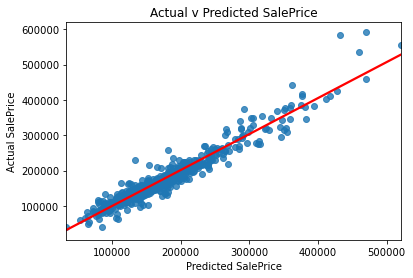

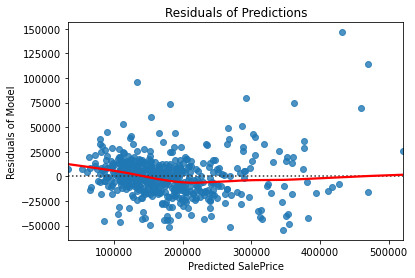

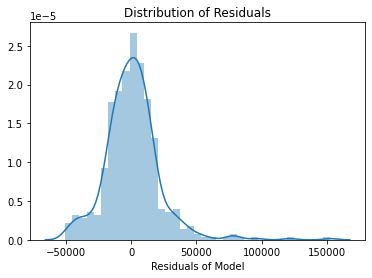

In [20]:
plt.figure();
sns.regplot(x=y_preds_e, y=y_test_e, line_kws={'color': 'r'}, ci=None);
plt.title('Actual v Predicted SalePrice');
plt.xlabel('Predicted SalePrice');
plt.ylabel('Actual SalePrice');

plt.figure();
sns.residplot(x=y_preds_e, y=y_test_e,lowess=True, line_kws={'color': 'r'});
plt.title('Residuals of Predictions');
plt.xlabel('Predicted SalePrice');
plt.ylabel('Residuals of Model');

plt.figure();
plt.title('Distribution of Residuals');
sns.distplot(np.subtract(y_test_e, y_preds_e));
plt.xlabel('Residuals of Model');

## Coefficients

In [21]:
cols = np.array(pipe.named_steps['stage'].staging_cols)

select1 = pipe.named_steps['sbf1'].index_cols
select2 = pipe.named_steps['sbf2'].index_cols
poly_sel = pipe.named_steps['poly'].get_feature_names(cols[select1])

selected1 = cols[select1]

selected2 = np.array(poly_sel)[select2]

coefs = np.array(pipe.named_steps['model'].coef_)

coefs = list(zip(coefs, selected2))
coefs.sort(reverse=True)

md_table = '| Feature Name  | Coefficient  | \n |---|---|'

for (coef, col) in coefs:
    md_table+=f'\n|{col}|{round(coef, 6)}|'

display(Markdown(md_table))

| Feature Name  | Coefficient  | 
 |---|---|
|Gr Liv Area|0.133893|
|Overall Qual|0.094387|
|Year Built|0.086387|
|Overall Cond|0.072152|
|Bsmt Exposure^2|0.060009|
|Lot Area|0.045892|
|BsmtFin SF 1|0.041672|
|Total Bsmt SF|0.037353|
|Fireplaces|0.026028|
|Bsmt Qual|0.021195|
|Kitchen Qual|0.019797|
|Garage Cars|0.018878|
|Exter Qual|0.018762|
|1st Flr SF|0.018328|
|Kitchen Qual Garage Cars|0.015473|
|Heating QC|0.015387|
|Bsmt Full Bath|0.011609|
|Lot Frontage|0.011464|
|Year Remod/Add|0.005976|
|Wood Deck SF|0.005386|
|Foundation_PConc|0.001357|
|Garage Yr Blt|0.0004|

## Test Data Submission

In [22]:
test_data = pd.read_csv('./datasets/test.csv')

y_final = un_log(pipe.predict(test_data))

index = pd.read_csv('./datasets/test.csv')
index = index['Id'].values

pd.DataFrame({'Id':index, 'SalePrice':y_final}).to_csv('./datasets/preds.csv', index=False)